In [26]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Normal
import copy
import matplotlib.pyplot as plt

In [27]:
import collections
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) 

    def add(self, state, action, reward, next_state, done): 
        self.buffer.append((state, action, reward, next_state, done)) 

    def sample(self, batch_size): 
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done 

    def size(self): 
        return len(self.buffer)

In [21]:
class PolicyNetContinuous(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim,action_bound):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fc_mu=nn.Sequential(nn.Linear(hidden_dim,action_dim))
        self.fc_var=nn.Sequential(nn.Linear(hidden_dim,action_dim))
        self.action_bound=action_bound
    def forward(self,x):
        x=self.fc1(x)
        mu=self.fc_mu(x)
        var=F.softplus(self.fc_var(x))
        dist=Normal(mu,var)
        normal_resample=dist.rsample()
        log_probs=dist.log_prob(normal_resample)
        action=torch.tanh(normal_resample)
        #计算Tanh_normal的概率密度
        log_probs=log_probs-torch.log(1-torch.tanh(action).pow(2)+1e-7)
        action=action*self.action_bound
        return action,log_probs

class QValueNetContinuous(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super().__init__()
        self.layers=nn.Sequential(
            nn.Linear(state_dim+action_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,1),
        )
    def forward(self,s,a):
        x=torch.cat([s,a],dim=-1)
        return self.layers(x)
        

In [37]:
class SACcontinuous():
    def __init__(
        self,
        state_dim,
        hidden_dim,
        action_dim,
        action_bound,
        actor_lr,
        critic_lr,
        alpha_lr,
        target_entropy,
        tau,
        gamma,
        device,
                ):
        
        self.actor=PolicyNetContinuous(state_dim,hidden_dim,action_dim,action_bound).to(device)
        
        self.Q1=QValueNetContinuous(state_dim,hidden_dim,action_dim).to(device)
        self.Q2=QValueNetContinuous(state_dim,hidden_dim,action_dim).to(device)
        self.target_Q1=copy.deepcopy(self.Q1)
        self.target_Q2=copy.deepcopy(self.Q2)
        
        self.optimizer_actor=torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.optimizer_Q1=torch.optim.Adam(self.Q1.parameters(),lr=critic_lr)
        self.optimizer_Q2=torch.optim.Adam(self.Q2.parameters(),lr=critic_lr)
        
        self.log_alpha=torch.tensor(np.log(0.01), dtype=torch.float).to(device)
        self.log_alpha.requires_grad=True
        self.optimizer_log_alpha=torch.optim.Adam([self.log_alpha],lr=alpha_lr)
        
        self.target_entropy=target_entropy
        self.gamma=gamma
        self.tau=tau
        self.device=device
    def take_action(self,state):
        state=torch.Tensor(state).unsqueeze(0).to(self.device)
        action=self.actor(state)[0]
        return [action.item()]
    def soft_update(self,net,target_net):
        for param,target_param in zip(net.parameters(),
                                     target_net.parameters()):
            target_param.data.copy_(param.data*self.tau+target_param.data*(1-self.tau))
    def cal_target(self,rewards,next_states,dones):
        next_actions,log_probs=self.actor(next_states)
        entropy=-log_probs
        Q1_value=self.target_Q1(next_states,next_actions)
        Q2_value=self.target_Q2(next_states,next_actions)
        next_value=torch.min(Q1_value,Q2_value)+self.log_alpha.exp()*entropy
        td_target=rewards+self.gamma*next_value*(1-dones)
        return td_target
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        # 和之前章节一样,对倒立摆环境的奖励进行重塑以便训练
        rewards = (rewards + 8.0) / 8.0
        
        ## 更新Q网络
        td_target=self.cal_target(rewards,next_states,dones).detach()
        q1,q2=self.Q1(states,actions),self.Q2(states,actions)
        Q1_loss=torch.mean(F.mse_loss(q1,td_target))
        Q2_loss=torch.mean(F.mse_loss(q2,td_target))
        self.optimizer_Q1.zero_grad()
        Q1_loss.backward()
        self.optimizer_Q1.step()
        self.optimizer_Q2.zero_grad()
        Q2_loss.backward()
        self.optimizer_Q2.step()
        
        ## 更新actor
        new_actions,log_probs=self.actor(states)
        entropy=-log_probs
        q1,q2=self.Q1(states,new_actions),self.Q2(states,new_actions)
        actor_loss=-torch.mean(torch.min(q1,q2)+self.log_alpha.exp()*entropy)
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()
        
        ## 更新alpha
        alpha_loss=torch.mean((entropy-self.target_entropy).detach()*self.log_alpha.exp())
        self.optimizer_log_alpha.zero_grad()
        alpha_loss.backward()
        self.optimizer_log_alpha.step()
        
        self.soft_update(self.Q1,self.target_Q1)
        self.soft_update(self.Q2,self.target_Q2)
        

In [40]:
import time
env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
epochs = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
replay_buffer =ReplayBuffer(buffer_size)
agent = SACcontinuous(state_dim, hidden_dim, action_dim, action_bound,
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau,
                      gamma, device)

from tqdm import tqdm
return_list=[]
for i in range(10):
    with tqdm(total=epochs//10,desc='iter %d'%i) as pbar:
        for epoch in range(epochs//10):
            rewards=0
            state,_=env.reset(seed=0)
            action=agent.take_action(state)
            done=False
            while not done:
                new_state,r,_,done,_=env.step(action)
                replay_buffer.add(state,action,r,new_state,done)
                new_action=agent.take_action(new_state)
                rewards+=r
                state=new_state
                action=new_action
                if replay_buffer.size()>minimal_size:
                    b_s,b_a,b_r,b_ns,b_d=replay_buffer.sample(batch_size)
                    tran_dict={
                        'states':b_s,
                        'actions':b_a,
                        'next_states':b_ns,
                        'rewards':b_r,
                        'dones':b_d,
                    }
                    agent.update(tran_dict)
                
            return_list.append(rewards)
            if (epoch+1) %10==0:
                pbar.set_postfix({
                    'epoch':'%d'%(epochs//10*i+epoch+1),
                    'return':'%.3f'%np.mean(return_list[-10:])
                })
            time.sleep(0.1)
            pbar.update(1)


iter 9: 100%|██████████| 10/10 [00:22<00:00,  2.24s/it, epoch=100, return=-127.766]


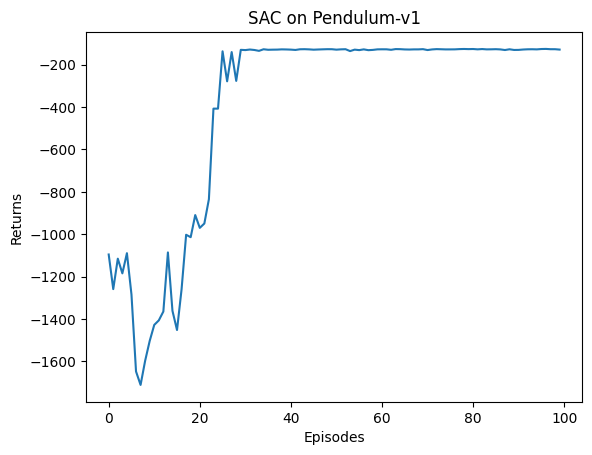

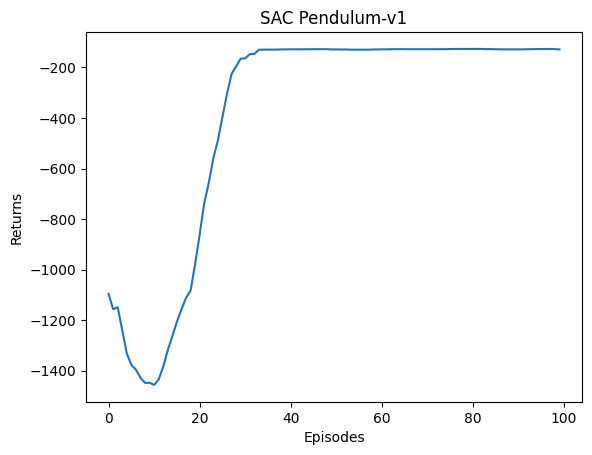

In [41]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))
mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC {}'.format(env_name))
plt.show()

## 离散空间SAC

In [28]:
class PolicyNet(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super().__init__()
        self.layers=nn.Sequential(
            nn.Linear(state_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,action_dim),
            nn.Softmax()
            
        )
    def forward(self,x):
        return self.layers(x)
class QValueNet(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super().__init__()
        self.layers=nn.Sequential(
            nn.Linear(state_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,action_dim),  
        )
    def forward(self,x):
        return self.layers(x)

In [38]:
class SAC():
    def __init__(
        self,
        state_dim,
        hidden_dim,
        action_dim,
        actor_lr,
        critic_lr,
        alpha_lr,
        target_entropy,
        tau,
        gamma,
        device,
                ):
        
        self.actor=PolicyNet(state_dim,hidden_dim,action_dim).to(device)
        
        self.Q1=QValueNet(state_dim,hidden_dim,action_dim).to(device)
        self.Q2=QValueNet(state_dim,hidden_dim,action_dim).to(device)
        self.target_Q1=copy.deepcopy(self.Q1)
        self.target_Q2=copy.deepcopy(self.Q2)
        
        self.optimizer_actor=torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.optimizer_Q1=torch.optim.Adam(self.Q1.parameters(),lr=critic_lr)
        self.optimizer_Q2=torch.optim.Adam(self.Q2.parameters(),lr=critic_lr)
        
        self.log_alpha=torch.tensor(np.log(0.01), dtype=torch.float).to(device)
        self.log_alpha.requires_grad=True
        self.optimizer_log_alpha=torch.optim.Adam([self.log_alpha],lr=alpha_lr)
        
        self.target_entropy=target_entropy
        self.gamma=gamma
        self.tau=tau
        self.device=device
    def take_action(self,state):
        state=torch.Tensor(state).unsqueeze(0).to(self.device)
        probs=self.actor(state)
        action_dist=torch.distributions.Categorical(probs)
        action=action_dist.sample()
        return action.item()
    def soft_update(self,net,target_net):
        for param,target_param in zip(net.parameters(),
                                     target_net.parameters()):
            target_param.data.copy_(param.data*self.tau+target_param.data*(1-self.tau))
    def cal_target(self,rewards,next_states,dones):
        probs=self.actor(next_states)
        log_probs=torch.log(probs+1e-8)
        entropy=-torch.sum(probs*log_probs,dim=1,keepdim=True)
        q1,q2=self.target_Q1(next_states),self.target_Q2(next_states)
        min_q_value=torch.sum(probs*torch.min(q1,q2),dim=1,keepdim=True)
        next_value=min_q_value+self.log_alpha.exp()*entropy
        td_target=rewards+self.gamma*next_value*(1-dones)
        return td_target
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        
        ## 更新Q网络
        td_target=self.cal_target(rewards,next_states,dones).detach()
        q1,q2=self.Q1(states).gather(1,actions),self.Q2(states).gather(1,actions)
        Q1_loss=torch.mean(F.mse_loss(q1,td_target))
        Q2_loss=torch.mean(F.mse_loss(q2,td_target))
        self.optimizer_Q1.zero_grad()
        Q1_loss.backward()
        self.optimizer_Q1.step()
        self.optimizer_Q2.zero_grad()
        Q2_loss.backward()
        self.optimizer_Q2.step()
        
        ## 更新actor
        probs=self.actor(states)
        log_probs=torch.log(probs+1e-8)
        entropy=-torch.sum(probs*log_probs,dim=1,keepdim=True)
        
        q1,q2=self.Q1(states),self.Q2(states)
        min_qvalue=torch.sum(probs*torch.min(q1,q2),dim=1,keepdim=True)
        actor_loss=-torch.mean(min_qvalue+self.log_alpha.exp()*entropy)
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()
        
        ## 更新alpha
        alpha_loss=torch.mean((entropy-self.target_entropy).detach()*self.log_alpha.exp())
        self.optimizer_log_alpha.zero_grad()
        alpha_loss.backward()
        self.optimizer_log_alpha.step()
        
        self.soft_update(self.Q1,self.target_Q1)
        self.soft_update(self.Q2,self.target_Q2)
        

In [44]:
import time
actor_lr = 5e-4
critic_lr = 1e-3
alpha_lr = 1e-3
epochs = 1000
hidden_dim = 128
gamma = 0.90
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 500
batch_size = 64
target_entropy = -1
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = SAC(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, alpha_lr,
            target_entropy, tau, gamma, device)

from tqdm import tqdm
return_list=[]
for i in range(10):
    with tqdm(total=epochs//10,desc='iter %d'%i) as pbar:
        for epoch in range(epochs//10):
            rewards=0
            state,_=env.reset(seed=0)
            action=agent.take_action(state)
            done=False
            done1=False
            done2=False
            while (not done1) and (not done2):
                new_state,r,done1,done2,_=env.step(action)
                done=done1 or done2
                replay_buffer.add(state,action,r,new_state,done)
                new_action=agent.take_action(new_state)
                rewards+=r
                state=new_state
                action=new_action
                if replay_buffer.size()>minimal_size:
                    b_s,b_a,b_r,b_ns,b_d=replay_buffer.sample(batch_size)
                    tran_dict={
                        'states':b_s,
                        'actions':b_a,
                        'next_states':b_ns,
                        'rewards':b_r,
                        'dones':b_d,
                    }
                    agent.update(tran_dict)
                
            return_list.append(rewards)
            if (epoch+1) %10==0:
                pbar.set_postfix({
                    'epoch':'%d'%(epochs//10*i+epoch+1),
                    'return':'%.3f'%np.mean(return_list[-10:])
                })
            pbar.update(1)
            time.sleep(0.1)



iter 9: 100%|██████████| 100/100 [03:56<00:00,  2.37s/it, epoch=1000, return=324.600]


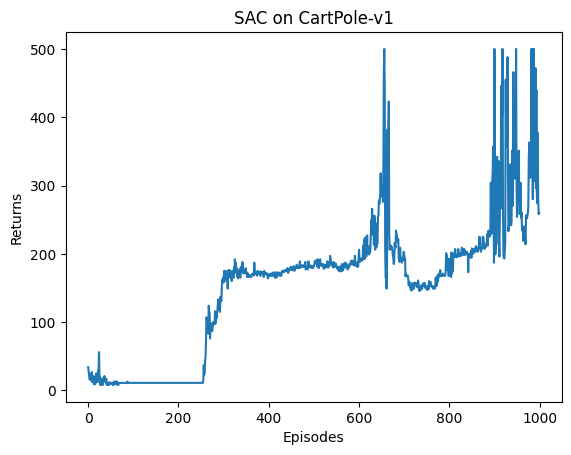

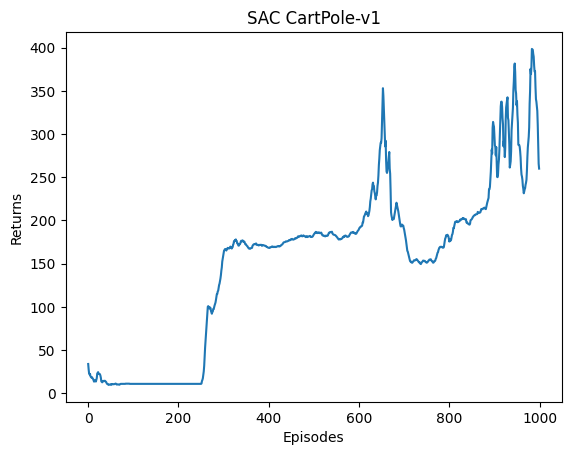

In [46]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))
mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC {}'.format(env_name))
plt.show()